## Setup

In [1]:
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import isuelogit as isl
import seaborn as sns
from datetime import datetime

In [2]:
from pesuelogit.visualizations import plot_heatmap_demands, plot_convergence_estimates
from pesuelogit.models import compute_rr
from pesuelogit.networks import load_k_shortest_paths, build_tntp_network
from pesuelogit.etl import get_design_tensor, add_period_id

In [3]:
# Internal modules
from nesuelogit.models import NESUELOGIT, ODParameters, UtilityParameters, BPR, MLP, KernelConstraint, \
    GenerationParameters, train_val_split_by_links, train_kfold, compute_generated_trips, compute_generation_factors, \
    create_inference_model, compute_benchmark_metrics, PolynomialLayer
from nesuelogit.visualizations import plot_predictive_performance, plot_metrics_kfold, \
    plot_top_od_flows_periods, plot_utility_parameters_periods, plot_flow_vs_traveltime, plot_mlp_performance_functions, \
    plot_annotate_r2
from nesuelogit.metrics import mse, btcg_mse, mnrmse, mape, r2, nrmse, zscore, nmse, z2score

In [4]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

main dir: /Users/pablo/github/nesuelogit


In [5]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [6]:
# To report global runtime
t0_global = time.time()

## Build network

In [7]:
network_name = 'SiouxFalls'
tntp_network = build_tntp_network(network_name=network_name)

## Read OD matrix

In [8]:
Q = isl.reader.read_tntp_od(network_name=network_name)
tntp_network.load_OD(Q=Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.3[s]                        

360600.0 trips were loaded among 528 o-d pairs


In [9]:
Q

array([[   0.,  100.,  100.,  500.,  200.,  300.,  500.,  800.,  500.,
        1300.,  500.,  200.,  500.,  300.,  500.,  500.,  400.,  100.,
         300.,  300.,  100.,  400.,  300.,  100.],
       [ 100.,    0.,  100.,  200.,  100.,  400.,  200.,  400.,  200.,
         600.,  200.,  100.,  300.,  100.,  100.,  400.,  200.,    0.,
         100.,  100.,    0.,  100.,    0.,    0.],
       [ 100.,  100.,    0.,  200.,  100.,  300.,  100.,  200.,  100.,
         300.,  300.,  200.,  100.,  100.,  100.,  200.,  100.,    0.,
           0.,    0.,    0.,  100.,  100.,    0.],
       [ 500.,  200.,  200.,    0.,  500.,  400.,  400.,  700.,  700.,
        1200., 1400.,  600.,  600.,  500.,  500.,  800.,  500.,  100.,
         200.,  300.,  200.,  400.,  500.,  200.],
       [ 200.,  100.,  100.,  500.,    0.,  200.,  200.,  500.,  800.,
        1000.,  500.,  200.,  200.,  100.,  200.,  500.,  200.,    0.,
         100.,  100.,  100.,  200.,  100.,    0.],
       [ 300.,  400.,  300.,  400.,

## Read paths

In [10]:
load_k_shortest_paths(network=tntp_network, k=3, update_incidence_matrices=True)

Generating at most 3 paths per od
1584 paths were generated among 528 od pairs in 0.2 [s]

1584 paths were loaded in the network
Matrix D (76, 1584) generated in 0.6[s]               

Matrix M (528, 1584) generated in 0.1[s]               

Matrix C (1584, 1584) generated in 0.0[s]               



## Read data

In [11]:
# Synthethic data which was generated under the assumption of path sets of size 2.
df = pd.read_csv(
    main_dir + '/input/network-data/' + tntp_network.key + '/links/' + tntp_network.key + '-link-data.csv')
df

,timepoint,link_key,tt_sd,s,period,traveltime,counts
0,1,"(0, 1, '0')",0.663287,0.608996,0,5.777197,10854.083139
1,1,"(0, 2, '0')",0.218225,0.823825,0,3.749994,7284.902475
2,1,"(1, 0, '0')",0.187173,0.182895,0,5.745494,5795.465951
3,1,"(1, 5, '0')",0.729779,0.786900,0,10.107062,7446.183725
4,1,"(2, 0, '0')",0.863313,0.311387,0,4.052389,19185.353647
...,...,...,...,...,...,...,...
22795,300,"(22, 21, '0')",0.118967,0.941838,2,6.372007,6274.259947
22796,300,"(22, 23, '0')",0.537956,0.516336,2,6.154877,8961.045591
22797,300,"(23, 12, '0')",0.054784,0.694868,2,30.290190,12055.066099
22798,300,"(23, 20, '0')",0.300521,0.431477,2,7.930908,7991.029966


In [12]:
# Generate synthetic node data
node_data = pd.DataFrame({'key': [node.key for node in tntp_network.nodes],
                          'income': np.random.rand(len(tntp_network.nodes)),
                          'population': np.random.rand(len(tntp_network.nodes))
                          })

## Exogenous features in utility function

In [13]:
_FEATURES_Z = ['tt_sd', 's']

## Training and validation sets

In [14]:
n_timepoints = len(df.timepoint.unique())
n_links = len(tntp_network.links)

# Add free flow travel times
df['tt_ff'] = np.tile([link.bpr.tf for link in tntp_network.links], n_timepoints)

In [15]:
period_feature = 'hour'
df = df.rename(columns = {'period': 'hour'})
df = add_period_id(df, period_feature=period_feature)

period_keys = df[[period_feature, 'period_id']].drop_duplicates().reset_index().drop('index', axis=1).sort_values(period_feature)
print(period_keys)

   hour  period_id
0     0          0
1     2          1


In [16]:
X = get_design_tensor(Z=df[_FEATURES_Z + ['period_id']], n_links=n_links, n_timepoints=n_timepoints )
Y = get_design_tensor(y=df[['traveltime', 'counts']], n_links=n_links, n_timepoints=n_timepoints)

# df_T = df[df.hour.isin([0, 5])]
df_T = df
XT = get_design_tensor(Z=df_T[_FEATURES_Z + ['period_id']], n_links=n_links, n_timepoints=n_timepoints )
YT = get_design_tensor(y=df_T[['traveltime', 'counts']], n_links=n_links, n_timepoints=n_timepoints)

In [17]:
_DTYPE = tf.float32

X, XT, Y, YT = [tf.cast(i, _DTYPE) for i in [X, XT, Y, YT]]

# Y_train, Y_val = train_val_split_by_links(Y.numpy(), val_size=0.05)
# YT_train, YT_val = train_val_split_by_links(YT.numpy(), val_size=0.05)

Y_train, Y_val = train_val_split_by_links(Y.numpy(), val_size=0)
YT_train, YT_val = train_val_split_by_links(YT.numpy(), val_size=0)


X_train, X_val = X, X
X_train, X_val, Y_train, Y_val = [tf.cast(i, _DTYPE) for i in [X_train, X_val, Y_train, Y_val]]

XT_train, XT_val = XT, XT
XT_train, XT_val, YT_train, YT_val = [tf.cast(i, _DTYPE) for i in [XT_train, XT_val, YT_train, YT_val]]

## Configuration

In [30]:
_LOSS_WEIGHTS = {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_EQUILIBRIUM_STAGE = True
_ALTERNATING_OPTIMIZATION = False

_LR = {'learning': 1e-1, 'equilibrium': 1e-1}

_BATCH_SIZE = 1
_EPOCHS = {'learning': 20, 'equilibrium': 10}
# _BATCH_SIZE = None
# _EPOCHS = {'learning': 2, 'equilibrium': 1}
_EPOCHS_PRINT_INTERVAL = {'learning': 1, 'equilibrium': 1}
_XTICKS_SPACING = 5

# With CPU
# _OPTIMIZERS = {'learning': tf.keras.optimizers.Adam(learning_rate=_LR['learning']),
#               'equilibrium': tf.keras.optimizers.Adam(learning_rate=_LR['equilibrium'])
#               }

# With GPU
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
               'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
               }

_RELATIVE_GAP = 1e-3

_LOSS_METRIC = z2score
# _LOSS_METRIC = zscore
# _LOSS_METRIC = nrmse
# _LOSS_METRIC = mse

## Models

In [19]:
models = {}
train_results_dfs = {}
val_results_dfs = {}

# Model creation

In [20]:
def create_mlp(network, dtype =_DTYPE):
    return MLP(n_links=len(network.links),
                           free_flow_traveltimes=[link.bpr.tf for link in network.links],
                           capacities=[link.bpr.k for link in network.links],
                           kernel_constraint=KernelConstraint(
                               link_keys=[(link.key[0], link.key[1]) for link in network.links],
                               # adjacency_constraint=True,
                               dtype=dtype,
                               capacities=[link.bpr.k for link in network.links],
                               free_flow_traveltimes=[link.bpr.tf for link in network.links],
                               diagonal=True,
                               homogenous=True
                           ),
                           trainable = True,
                           polynomial_layer= PolynomialLayer(poly_order=3,
                                                             trainable = True,
                                                             pretrain_weights=True,
                                                             alpha_prior = 1, beta_prior=2
                                                             ),
                           alpha_relu = 0.1,
                           depth=1,
                           dtype=dtype)

def create_bpr(network, dtype =_DTYPE):
    return BPR(keys=['alpha', 'beta'],
               # initial_values={'alpha': 0.15, 'beta': 4},
               initial_values={'alpha': 1, 'beta': 1}, # Consistent with MLP initialization
               # initial_values={'alpha': 0.15 * tf.ones(len(network.links), dtype = dtype),
               #                 'beta': 4 * tf.ones(len(network.links), dtype = dtype)},
               true_values={'alpha': 0.15, 'beta': 4},
               trainables={'alpha': True, 'beta':True},
               capacities = [link.bpr.k for link in network.links],
               free_flow_traveltimes =[link.bpr.tf for link in network.links],
               dtype = dtype
               )

def create_tvodlulpe_model_siouxfalls(network, dtype=_DTYPE, n_periods=1, features_Z=_FEATURES_Z, historic_g=None,
                                      performance_function=None):
    # optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           # trainables={'psc_factor': False, 'fixed_effect': False
                                           #     , 'tt': True, 'tt_sd': True, 's': True},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'tt_sd': False, 's': False},
                                           time_varying=True,
                                           dtype=dtype
                                           )

    # utility_parameters.random_initializer((-1,1),['tt','tt_sd','s'])
    utility_parameters.random_initializer((0, 0), ['tt', 'tt_sd', 's'])

    if performance_function is None:
        # performance_function = create_bpr(network = network, dtype = dtype)
        performance_function = create_mlp(network = network, dtype = dtype)

    od_parameters = ODParameters(key='od',
                                 initial_values=network.q.flatten(),
                                 true_values=network.q.flatten(),
                                 # historic_values={0: network.q.flatten()},
                                 # total_trips={0: np.sum(network.Q)},
                                 ods=network.ods,
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True)

    generation_parameters = GenerationParameters(
        features_Z=['income', 'population'],
        initial_values={
            # 'income': 0,
            'fixed_effect': historic_g,
        },
        keys=['fixed_effect_od', 'fixed_effect_origin', 'fixed_effect_destination'],
        # true_values={'income': 0, 'fixed_effect': np.zeros_like(network.links)},
        # signs = {'income': '+','population': '+'},
        trainables={
            'fixed_effect': False, 'income': False, 'population': False,
            'fixed_effect_origin': False, 'fixed_effect_destination': False, 'fixed_effect_od': True
            # 'fixed_effect_origin': False, 'fixed_effect_destination': True, 'fixed_effect_od': False
        },
        pretrain_generation_weights=False,
        historic_g= historic_g,
        dtype=dtype
    )

    model = NESUELOGIT(
        key='tvodlulpe',
        network=network,
        dtype=dtype,
        utility=utility_parameters,
        performance_function=performance_function,
        generation=generation_parameters,
        od=od_parameters,
        n_periods=n_periods
    )

    return model, {'utility_parameters': utility_parameters, 'generation_parameters': generation_parameters,
                   'od_parameters': od_parameters, 'performance_function': performance_function}

### Equilibrium

Gradient based SUELOGIT

Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: 0.0001
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan
Equilibrium stage: 200 epochs

0/200: train mse=1.2e+08, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05 2.9e+05], lambda eq=1, relative gap=0.55, kappa = [0. 0.], train equilibrium loss=1.2e+08, val equilibrium loss=0, time: 0.1

1/200: train mse=1.2e+08, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05 2.9e+05], lambda eq=1, relative gap=0.52, kappa = [0. 0.], train equilibrium loss=1.2e+08, val equilibrium loss=0, time: 9.4

2/200: train mse=1.1e+08, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, los

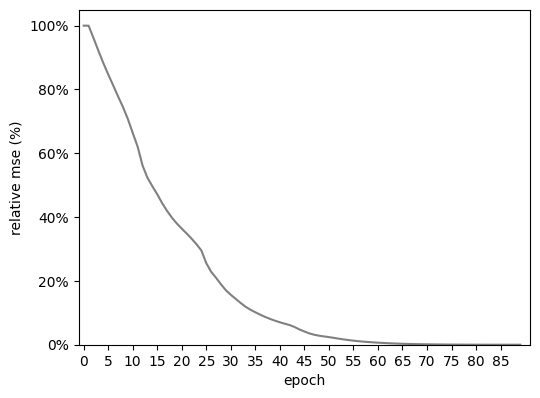

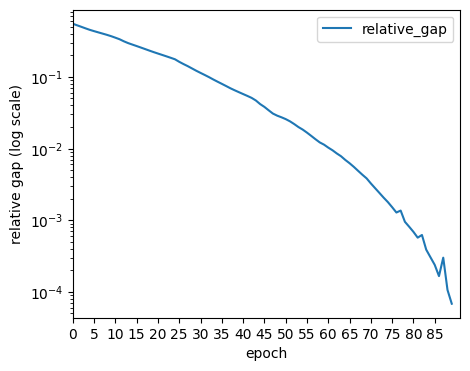


runtime: 664.3 [s]


In [22]:
print('Gradient based SUELOGIT')

# To report runtime
t0 = time.time()

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generation_factors = compute_generation_factors(period_column=X[:, :, -1, None].numpy(),
                                                flow_column=Y[:, :, 1, None].numpy(), reference_period=0)
# generation_factors = np.array([1,1])

generated_trips = compute_generated_trips(q=isl.networks.denseQ(Q).flatten()[np.newaxis, :],
                                          ods=tntp_network.ods)

suelogit, _ = create_tvodlulpe_model_siouxfalls(network = tntp_network,
                                                n_periods= n_periods,
                                                historic_g= generation_factors.values[:,np.newaxis]*generated_trips)

train_results_dfs['suelogit'], val_results_dfs['suelogit'] = suelogit.compute_equilibrium(
    XT_train,
    node_data=node_data,
    loss_metric=_LOSS_METRIC,
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-3),
    batch_size=1,
    loss_weights={'equilibrium': 1},
    threshold_relative_gap=1e-3,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=200)

train_results_estimates, train_results_losses = suelogit.split_results(results=train_results_dfs['suelogit'])
val_results_estimates, val_results_losses = suelogit.split_results(results=val_results_dfs['suelogit'])

plot_predictive_performance(train_losses=train_results_dfs['suelogit'], val_losses=val_results_dfs['suelogit'],
                            xticks_spacing=5, curves=['equilibrium'])

fig, ax = plot_convergence_estimates(
    estimates=train_results_losses.assign(
        relative_gap=np.abs(train_results_losses['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=5)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')

plt.show()

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

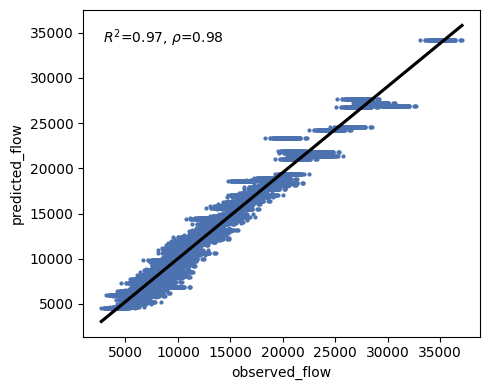

In [27]:
# Check that link flows at equilibrium are close to the observed link flows, as the latter where generated with the assumption of equilibrium
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

plot_data = pd.DataFrame({'predicted_flow': suelogit.predict_flow().numpy().flatten(),
                          'observed_flow': suelogit.mask_observed_flow(Y[:,:,1]).numpy().flatten(),
                          })

sns.regplot(data=plot_data, x='observed_flow', y='predicted_flow', ax=ax,
            scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},)

plot_annotate_r2(ax = ax, x = plot_data['observed_flow'], y = plot_data['predicted_flow'], all_metrics = False)

plt.show()

## TVODLULPE

In [31]:
print('\ntvodlulpe: Time specific utility and OD, link performance parameters, no historic OD')

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generation_factors = compute_generation_factors(period_column=X[:, :, -1, None].numpy(),
                                                flow_column=Y[:, :, 1, None].numpy(), reference_period=0)
# generation_factors = np.array([1,1])

generated_trips = compute_generated_trips(q=isl.networks.denseQ(Q).flatten()[np.newaxis, :],
                                          ods=tntp_network.ods)


tvodlulpe: Time specific utility and OD, link performance parameters, no historic OD


## MLP

In [32]:

models['tvodlulpe-mlp'], _ = create_tvodlulpe_model_siouxfalls(
    n_periods= n_periods, network = tntp_network,
    historic_g= generation_factors.values[:,np.newaxis]*generated_trips,
    # historic_g= generated_trips
    performance_function = create_mlp(network = tntp_network, dtype = _DTYPE)
)

train_results_dfs['tvodlulpe-mlp'], val_results_dfs['tvodlulpe-mlp'] = models['tvodlulpe-mlp'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
           'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    # generalization_error={'train': False, 'validation': True},
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    #loss_weights = {'od': 0, 'theta': 0, 'traveltime': 1e0, 'flow': 1, 'equilibrium': 1},
    loss_metric= _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)


Model training

 Benchmark metrics using mean in training data as predictions:  

    component    value metric
0        flow       42   mape
1  traveltime  1.7e+02   mape
0        flow  3.8e+07    mse
1  traveltime  3.4e+02    mse
0        flow -1.1e-08     r2
1  traveltime  2.1e-08     r2

hyperparameters loss function: {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: 0.001
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
validation set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]

Learning stage: 20 epochs

0/30: train mse=1.5e+08, train mse traveltime=8.5e+02, train mape traveltime=79.9 train mse flow=3.3e+07, train mape flow=29.5, val mse=1.5e+08, val mse traveltime=8.5e+02, val mape traveltime=79.9 val mse flow=3.3e+07, val mape flow=29.5, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od=nan, loss n

In [38]:
models['tvodlulpe-mlp'].save_weights(models['tvodlulpe-mlp']._filepath_weights)

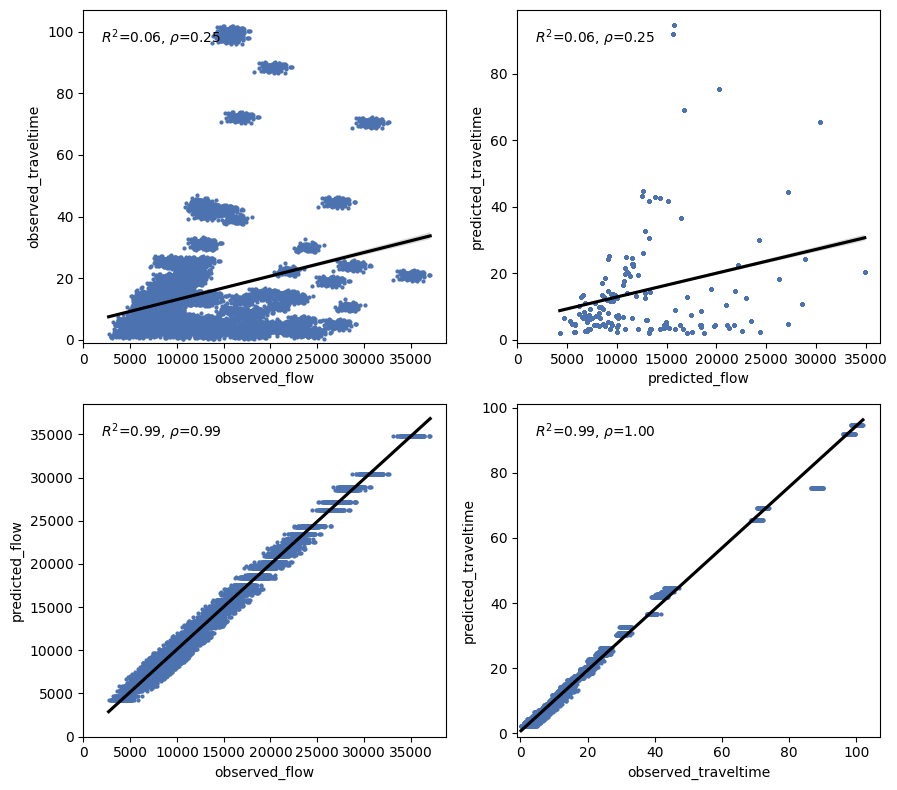

In [39]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe-mlp'],
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )
for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)

axs[1,1].set_xlim(xmin=-1)

plt.show()

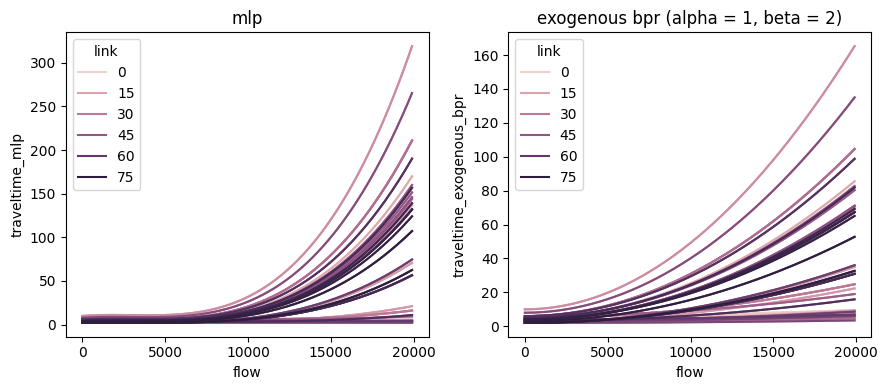

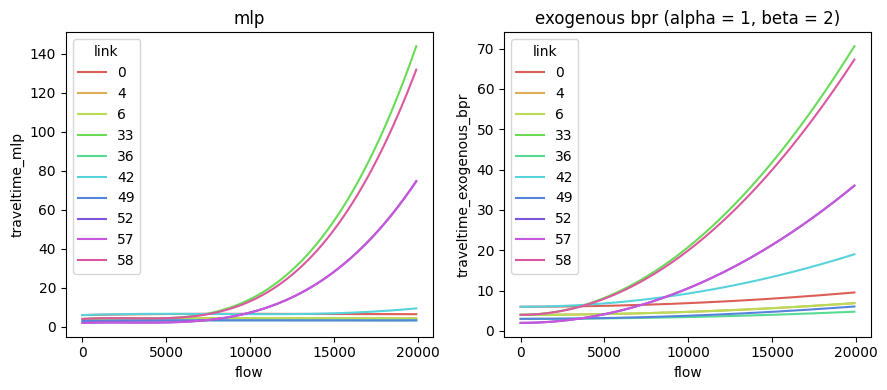

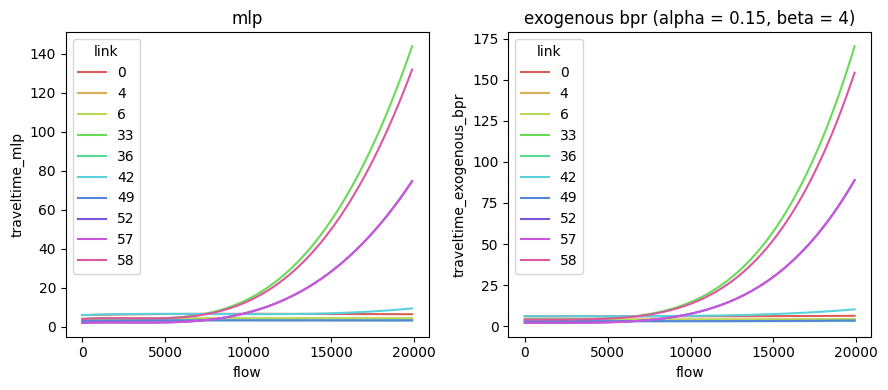

In [40]:

plot_mlp_performance_functions(model = models['tvodlulpe-mlp'],
                           network = tntp_network,
                           marginal = False,
                           alpha = 1,
                           beta = 2
                           # selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)
                           )

plt.show()

selected_links = np.random.choice(range(tntp_network.get_n_links()), 10, replace=False)

# Plot with bpr used the priors of the BPR parameters used to pretrain the MLP
plot_mlp_performance_functions(model=models['tvodlulpe-mlp'],
                           network=tntp_network,
                           marginal=False,
                           alpha=1,
                           beta=2,
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links))
                           )

plt.show()

plot_mlp_performance_functions(model=models['tvodlulpe-mlp'],
                           network=tntp_network,
                           marginal=False,
                           alpha=0.15,
                           beta=4,
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links))
                           )

plt.show()

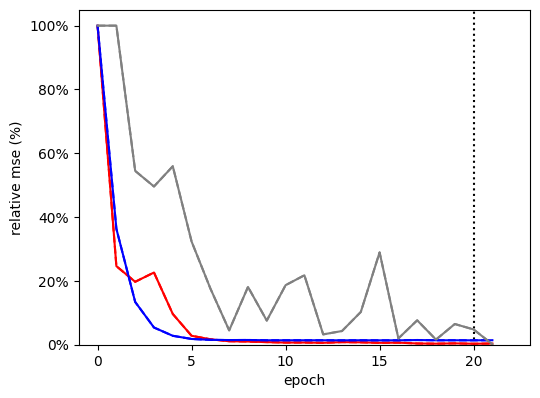

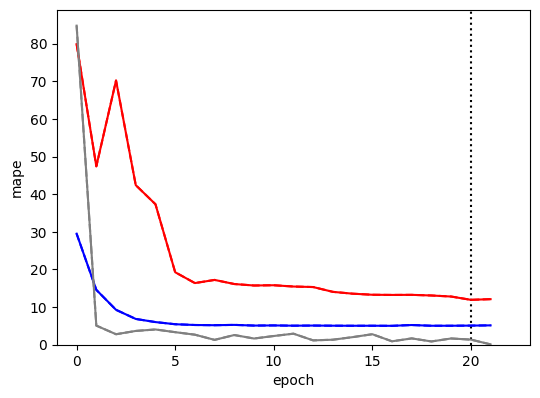

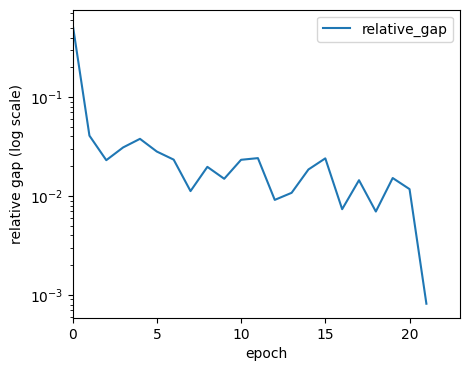

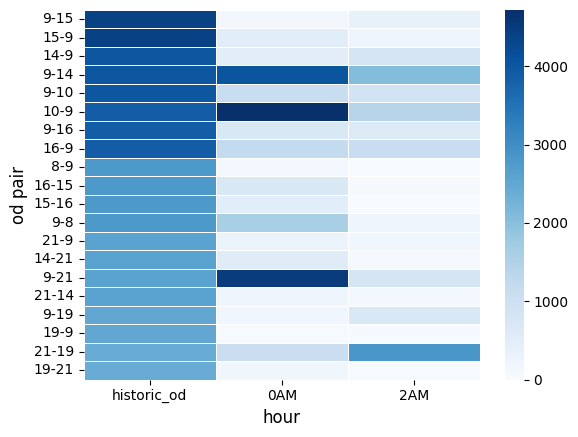

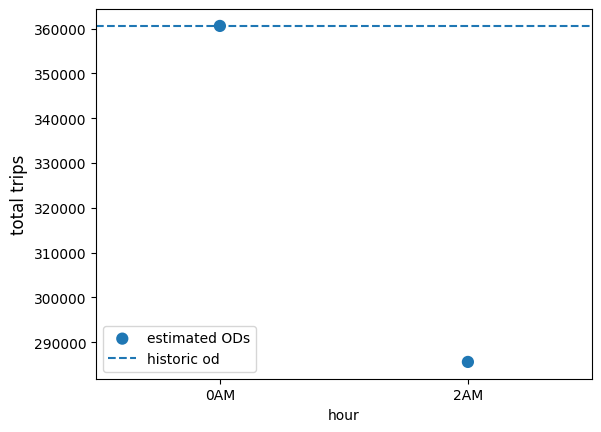

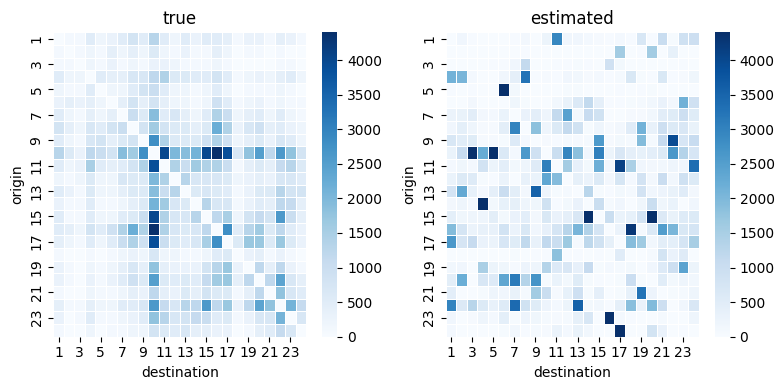

In [41]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe-mlp'],
                            val_losses=val_results_dfs['tvodlulpe-mlp'],
                            # curves = ['link flow', 'travel time'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=True,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe-mlp'],
                            val_losses=val_results_dfs['tvodlulpe-mlp'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=True,
                            # curves = ['link flow', 'travel time'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')


fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe-mlp'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe-mlp']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')

plt.show()

# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe-mlp'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          historic_od=tntp_network.q.flatten())


Qs = {'true': tntp_network.OD.Q_true,
      # 'historic': Q_historic,
      'estimated': tf.sparse.to_dense(models['tvodlulpe-mlp'].Q).numpy()}

plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, len(Qs.keys())),
                     figsize=(4*len(Qs.keys()), 4))

plt.show()

In [42]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe-mlp'].utility.true_values.keys(), list(np.mean(models['tvodlulpe-mlp'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvodlulpe-mlp'].generation.features, list(np.mean(models['tvodlulpe-mlp'].kappa.numpy(), axis=0))))}")

if models['tvodlulpe-mlp'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe-mlp'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe-mlp'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe-mlp'].q - tntp_network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(tntp_network.q.flatten())): 0.2f}")

theta = {'tt': -1.0, 'tt_sd': -1.3, 's': -3.0}
kappa= {'income': 0.0, 'population': 0.0}
Avg abs diff of observed and estimated OD:  779.47
Avg observed OD:  682.95
metric                    mape     mse       r2
component   dataset                            
equilibrium training      0.09 1.4e+03        1
            validation    0.09 1.4e+03        1
flow        benchmark       42 3.8e+07 -1.1e-08
            training       5.1 4.7e+05     0.99
            validation     5.1 4.7e+05     0.99
traveltime  benchmark  1.7e+02 3.4e+02  2.1e-08
            training        12     3.2     0.99
            validation      12     3.2     0.99


In [ ]:
metrics_df = models['tvodlulpe-mlp'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
metrics_df = pd.concat([metrics_df,
                        models['tvodlulpe-mlp'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2},
                                                                 X=XT_val, Y=YT_val).assign(dataset='validation'),
                        compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2}, Y_ref=YT_train,
                                                  Y=YT_val).assign(
                            dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

### BPR

In [43]:

models['tvodlulpe-bpr'], _ = create_tvodlulpe_model_siouxfalls(
    n_periods= n_periods, network = tntp_network,
    historic_g= generation_factors.values[:,np.newaxis]*generated_trips,
    # historic_g= generated_trips
    performance_function = create_bpr(network = tntp_network, dtype = _DTYPE)
)

train_results_dfs['tvodlulpe-bpr'], val_results_dfs['tvodlulpe-bpr'] = models['tvodlulpe-bpr'].fit(
    XT_train, YT_train, XT_val, YT_val,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
           'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    # generalization_error={'train': False, 'validation': True},
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    #loss_weights = {'od': 0, 'theta': 0, 'tt': 1e0, 'flow': 1, 'equilibrium': 1}, # If MLP
    loss_metric= _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)


Model training

 Benchmark metrics using mean in training data as predictions:  

    component    value metric
0        flow       42   mape
1  traveltime  1.7e+02   mape
0        flow  3.8e+07    mse
1  traveltime  3.4e+02    mse
0        flow -1.1e-08     r2
1  traveltime  2.1e-08     r2

hyperparameters loss function: {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: 0.001
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
validation set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]

Learning stage: 20 epochs

0/30: train mse=1e+08, train mse traveltime=2.4e+02, train mape traveltime=46.8 train mse flow=3.3e+07, train mape flow=29.5, val mse=1e+08, val mse traveltime=2.4e+02, val mape traveltime=46.8 val mse flow=3.3e+07, val mape flow=29.5, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od=nan, loss ntr

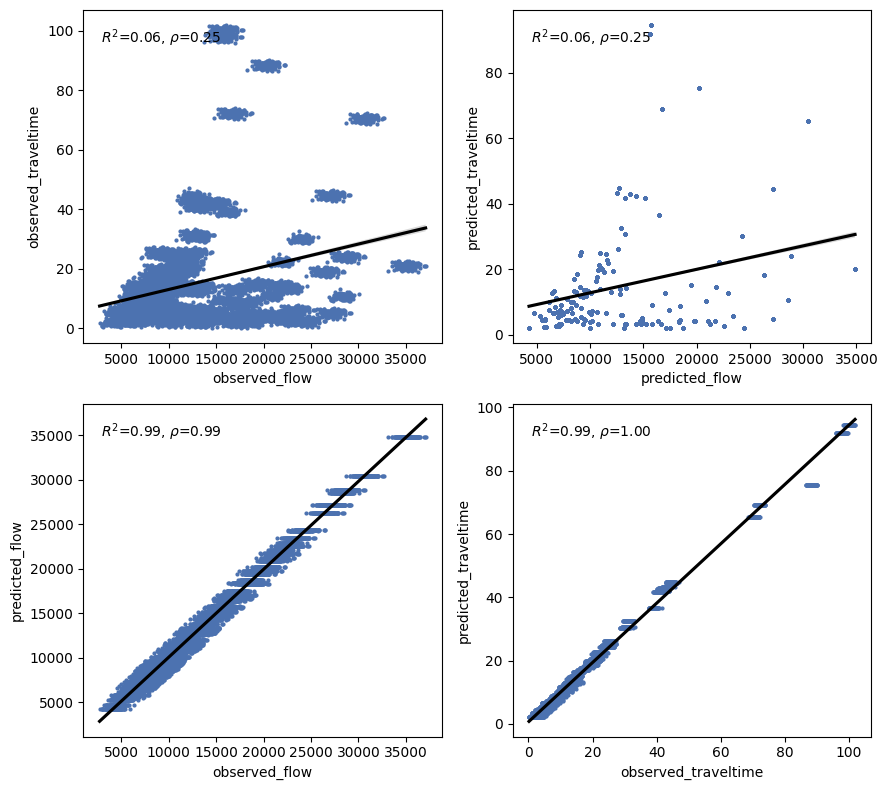

In [45]:
plot_flow_vs_traveltime(model = models['tvodlulpe-mlp'],
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)

axs[1,1].set_xlim(xmin=-1)

plt.show()

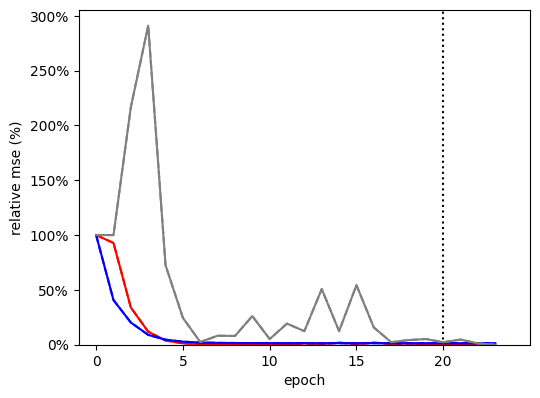

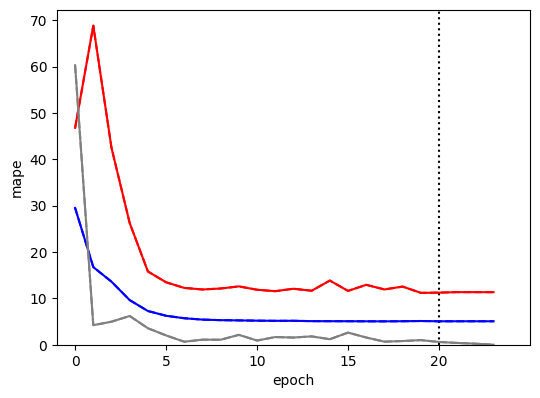

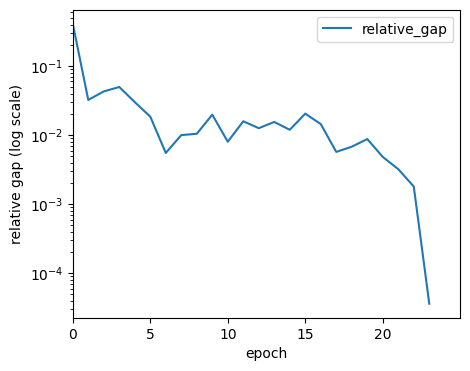

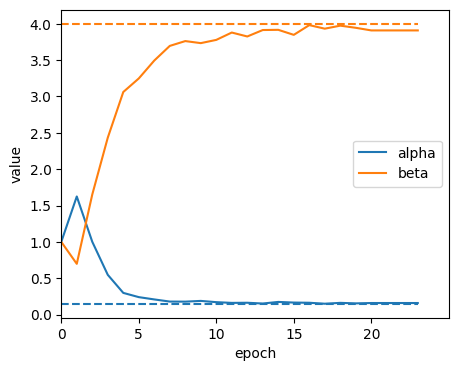

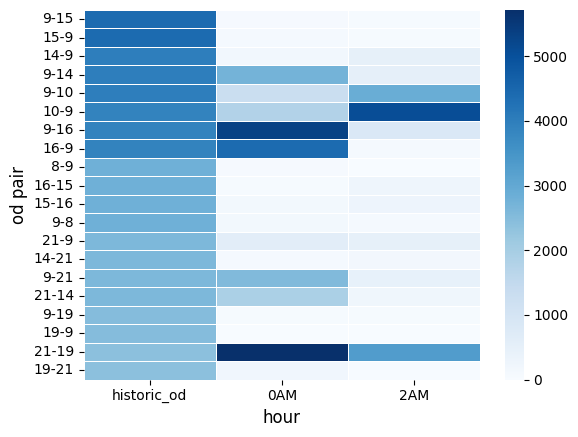

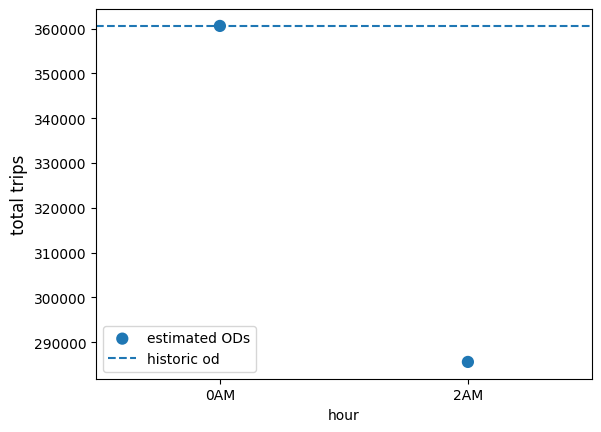

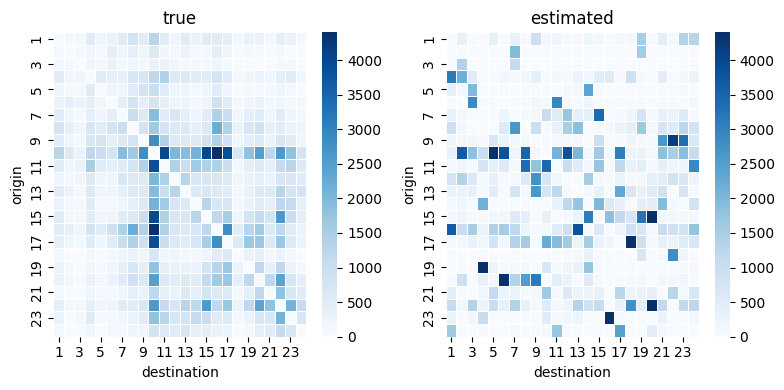

In [46]:

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe-bpr'],
                            val_losses=val_results_dfs['tvodlulpe-bpr'],
                            # curves = ['link flow', 'travel time'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=True,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe-bpr'],
                            val_losses=val_results_dfs['tvodlulpe-bpr'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=True,
                            # curves = ['link flow', 'travel time'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')


fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe-bpr'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe-bpr']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')

plt.show()

if models['tvodlulpe-bpr'].performance_function.type == 'bpr':
    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe-bpr'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=_XTICKS_SPACING,
                               true_values=models['tvodlulpe-bpr'].performance_function.parameters.true_values,
                               )

    # sns.displot(pd.melt(pd.DataFrame({'alpha': [float(tvodlulpe.performance_function._alpha)],
    #                                   'beta': [float(tvodlulpe.performance_function.beta)]}), var_name='parameters'),
    #             x="value", hue="parameters", multiple="stack", kind="kde", alpha=0.8)

    plt.show()

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
# theta_df = plot_utility_parameters_periods(models['tvodlulpe-bpr'], period_keys=period_keys, period_feature='hour')

# plt.show()

# rr_df = theta_df.apply(compute_rr, axis=1).reset_index().rename(columns={'index': period_feature, 0: 'rr'})

# sns.lineplot(data=rr_df, x=period_feature, y="rr")
#
# plt.show()

# sns.displot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe-bpr'].fixed_effect)}),
#             x="fixed_effect", multiple="stack", kind="kde", alpha=0.8)
#
# plt.show()

# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe-bpr'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          historic_od=tntp_network.q.flatten())


Qs = {'true': tntp_network.OD.Q_true,
      # 'historic': Q_historic,
      'estimated': tf.sparse.to_dense(models['tvodlulpe-bpr'].Q).numpy()}

plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, len(Qs.keys())),
                     figsize=(4*len(Qs.keys()), 4))

plt.show()

In [47]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe-bpr'].utility.true_values.keys(), list(np.mean(models['tvodlulpe-bpr'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvodlulpe-bpr'].generation.features, list(np.mean(models['tvodlulpe-bpr'].kappa.numpy(), axis=0))))}")

if models['tvodlulpe-bpr'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe-bpr'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe-bpr'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe-bpr'].q - tntp_network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(tntp_network.q.flatten())): 0.2f}")

metrics_df = models['tvodlulpe-bpr'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
metrics_df = pd.concat([metrics_df,
                        models['tvodlulpe-bpr'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2},
                                                                 X=XT_val, Y=YT_val).assign(dataset='validation'),
                        compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2}, Y_ref=YT_train,
                                                  Y=YT_val).assign(
                            dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

theta = {'tt': -1.0, 'tt_sd': -1.3, 's': -3.0}
kappa= {'income': 0.0, 'population': 0.0}
alpha =  0.16, beta  =  3.91
Avg abs diff of observed and estimated OD:  773.69
Avg observed OD:  682.95
metric                    mape     mse       r2
component   dataset                            
equilibrium training    0.0038    0.94        1
            validation  0.0038    0.94        1
flow        benchmark       42 3.8e+07 -1.1e-08
            training       5.1 4.6e+05     0.99
            validation     5.1 4.6e+05     0.99
traveltime  benchmark  1.7e+02 3.4e+02  2.1e-08
            training        11    0.72        1
            validation      11    0.72        1


## K-Fold Cross Validation

In [48]:
print('\ntvodlulpe-kfold: Time specific utility and OD, link performance parameters, no historic OD')

n_periods = len(np.unique(X[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q=isl.networks.denseQ(Q).flatten()[np.newaxis, :],
                                          ods=tntp_network.ods)


tvodlulpe-kfold: Time specific utility and OD, link performance parameters, no historic OD


### MLP

In [51]:
metrics_kfold_mlp_df = train_kfold(
    n_splits=20,
    random_state=_SEED,
    # random_state=10,
        model= create_tvodlulpe_model_siouxfalls(
            n_periods=n_periods, network=tntp_network,
            historic_g=generated_trips,
        performance_function = create_mlp(network = tntp_network, dtype = _DTYPE),
    )[0],
    X=X, Y=Y,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
               'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    # generalization_error={'train': False, 'validation': True},
    node_data=node_data,
    loss_weights= {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1},
    loss_metric = _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    # batch_size=None,
    # epochs={'learning': 3, 'equilibrium': 5},
    epochs_print_interval={'learning': 100, 'equilibrium': 100},
    epochs={'learning': 30, 'equilibrium': 10}
)

metrics_kfold_mlp_df.to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_{network_name}.csv")


Fold 1/20

Model training

 Benchmark metrics using mean in training data as predictions:  

    component   value metric
0        flow      46   mape
1  traveltime      94   mape
0        flow 2.3e+07    mse
1  traveltime 1.3e+03    mse
0        flow  -0.028     r2
1  traveltime   -0.12     r2

hyperparameters loss function: {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: 0.001
training set -> timepoints: 300, obs [t x]: [72. 72.], coverage [t x]: [0.95 0.95]
validation set -> timepoints: 300, obs [t x]: [4. 4.], coverage [t x]: [0.05 0.05]

Learning stage: 30 epochs

0/40: train mse=1.8e+08, train mse traveltime=1.2e+03, train mape traveltime=99.3 train mse flow=3.8e+07, train mape flow=32.1, val mse=2e+08, val mse traveltime=7.7e+02, val mape traveltime=159.4 val mse flow=6.2e+07, val mape flow=55.0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od=na

In [52]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold_mlp_df. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

                                          median     mean     std
dataset    component   metric stage                              
training   equilibrium mape   final        0.046    0.054   0.034
                              initial         87       87       0
                       mse    final      2.1e+02  5.8e+02 7.6e+02
                              initial    1.4e+08  1.4e+08       0
                       r2     final            1        1   2e-05
                              initial       -1.5     -1.5       0
           flow        mape   benchmark       43       42     1.1
                              final          5.1      5.4    0.77
                              initial         34       33     1.1
                       mse    benchmark  3.8e+07  3.8e+07 1.9e+06
                              final      4.8e+05  5.7e+05 2.6e+05
                              initial      4e+07  3.9e+07   3e+06
                       r2     benchmark -5.1e-10 -4.9e-09   1e-08
          

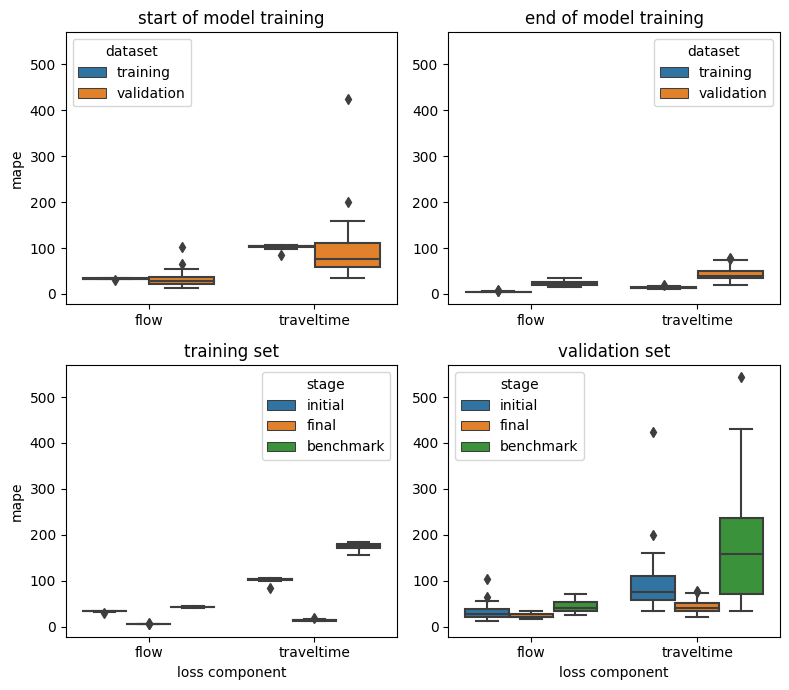

In [58]:
plot_metrics_kfold(df=metrics_kfold_mlp_df[metrics_kfold_mlp_df.component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = True)

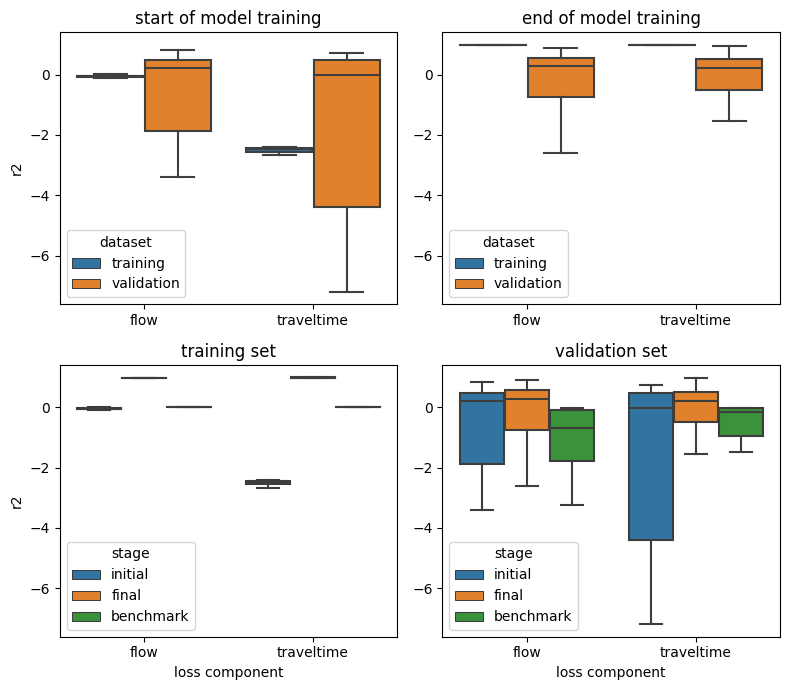

In [60]:
plot_metrics_kfold(df=metrics_kfold_mlp_df[metrics_kfold_mlp_df.component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False)

### BPR

In [55]:
metrics_kfold_bpr_df = train_kfold(
    n_splits=20,
    random_state=_SEED,
    # random_state=10,
    model= create_tvodlulpe_model_siouxfalls(
            n_periods=n_periods, network=tntp_network,
            historic_g=generated_trips,
            performance_function = create_bpr(network = tntp_network, dtype = _DTYPE),
    )[0],
    X=X, Y=Y,
    optimizers= {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
               'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])},
    # generalization_error={'train': False, 'validation': True},
    node_data=node_data,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric = _LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    # batch_size=None,
    # epochs={'learning': 3, 'equilibrium': 5},
    epochs_print_interval={'learning': 100, 'equilibrium': 100},
    epochs= {'learning': 20, 'equilibrium': 10}
)

metrics_kfold_bpr_df.to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_{network_name}.csv")


Fold 1/20

Model training

 Benchmark metrics using mean in training data as predictions:  

    component   value metric
0        flow      46   mape
1  traveltime      94   mape
0        flow 2.3e+07    mse
1  traveltime 1.3e+03    mse
0        flow  -0.028     r2
1  traveltime   -0.12     r2

hyperparameters loss function: {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: 0.001
training set -> timepoints: 300, obs [t x]: [72. 72.], coverage [t x]: [0.95 0.95]
validation set -> timepoints: 300, obs [t x]: [4. 4.], coverage [t x]: [0.05 0.05]

Learning stage: 20 epochs

0/30: train mse=1.2e+08, train mse traveltime=2.1e+02, train mape traveltime=50.6 train mse flow=3.8e+07, train mape flow=32.1, val mse=1.4e+08, val mse traveltime=8.1e+02, val mape traveltime=66.0 val mse flow=6.2e+07, val mape flow=55.0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od

KeyboardInterrupt: 

In [ ]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold_bpr_df. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

In [ ]:
plot_metrics_kfold(df=metrics_kfold_bpr_df[metrics_kfold_bpr_df.component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False)

In [ ]:
plot_metrics_kfold(df=metrics_kfold_bpr_df[metrics_kfold_bpr_df.component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False)

## Predictive power

In [61]:
print('\ntvodlulpe-outofsample')

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generation_factors = compute_generation_factors(period_column=XT[:, :, -1, None].numpy(),
                                                flow_column=YT[:,:,1, None].numpy(), reference_period=0)

generated_trips = compute_generated_trips(q = isl.networks.denseQ(Q).flatten()[np.newaxis,:],
                                          ods= tntp_network.ods)

reference_model, _ = create_tvodlulpe_model_siouxfalls(
        n_periods=n_periods, network=tntp_network,
        historic_g=generation_factors.values[:, np.newaxis] * generated_trips)

reference_model.build()

reference_model.load_weights(models['tvodlulpe-mlp']._filepath_weights)


tvodlulpe-outofsample


In [62]:
reference_model.fit(
    XT_train, YT_train,
    optimizers=_OPTIMIZERS,
    # generalization_error={'train': False, 'validation': True},
    node_data=node_data,
    # batch_size=_BATCH_SIZE,
    batch_size=None,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    # epochs=_EPOCHS
    epochs={'learning': 0, 'equilibrium': 5}
)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    print(reference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2}, X=XT_train, Y=YT_train))


Model training

hyperparameters loss function: {'od': 0, 'theta': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 300, threshold relative gap: 0.001
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
Equilibrium stage: 5 epochs

0/5: train mse=4.7e+05, train mse traveltime=3.2, train mape traveltime=12.1 train mse flow=4.7e+05, train mape flow=5.1, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05 2.9e+05], lambda eq=1, relative gap=0.00082, kappa = [0. 0.], train equilibrium loss=1.4e+03, val equilibrium loss=0, time: 0.1


     component    value metric
0         flow     5.14   mape
1   traveltime     12.1   mape
2  equilibrium   0.0903   mape
0         flow 4.68e+05    mse
1   traveltime     3.18    mse
2  equilibrium 1.42e+03    mse
0         flow    0.988     r2
1   traveltime    0.991     r2
2  equilibrium        1     r2


In [64]:
inference_model = create_inference_model(creation_method = create_tvodlulpe_model_siouxfalls, reference_model=reference_model)

# model.summary()

inference_model.predict(XT_val,
              period_dict={k: v for k, v in reference_model.period_dict.items()},
              node_data=node_data,
              loss_metric=_LOSS_METRIC,
              optimizer=_OPTIMIZERS['equilibrium'],
              # batch_size= 1,
              loss_weights={'equilibrium': 1},
              threshold_relative_gap=1e-3,  # _RELATIVE_GAP,
              epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
              epochs=4)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    print(inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2}, X=XT_val, Y=YT_val))


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 300, threshold relative gap: 0.001
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan
Equilibrium stage: 4 epochs

0/4: train mse=1.4e+03, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05 2.9e+05], lambda eq=1, relative gap=0.00082, kappa = [0. 0.], train equilibrium loss=1.4e+03, val equilibrium loss=0, time: 0.1


     component    value metric
0         flow     5.14   mape
1   traveltime     12.1   mape
2  equilibrium   0.0903   mape
0         flow 4.68e+05    mse
1   traveltime     3.18    mse
2  equilibrium 1.42e+03    mse
0         flow    0.988     r2
1   traveltime    0.991     r2
2  equilibrium        1     r2


In [65]:
# Bad model because it has not been trained
other_model = create_tvodlulpe_model_siouxfalls(
    historic_g=generated_trips * generation_factors.values[:, np.newaxis], network = tntp_network)[0]

other_model.build()
other_model.setup_period_ids(X_train=XT_val, node_data=node_data)
# other_model.forward(XT_val)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    print(other_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2}, X=XT_val, Y=YT_val))



     component    value metric
0         flow      100   mape
1   traveltime       53   mape
2  equilibrium      NaN   mape
0         flow 2.08e+08    mse
1   traveltime      452    mse
2  equilibrium 2.13e+08    mse
0         flow    -4.55     r2
1   traveltime   -0.338     r2
2  equilibrium        0     r2


## Write predictions

In [ ]:
# TODO: predictions are not supported for tvodlulpe model yet

In [ ]:
predictions = pd.DataFrame({'link_key': list(tntp_network.links_keys) * Y_train.shape[0],
                            'observed_traveltime': Y_train[:, :, 0].numpy().flatten(),
                            'observed_flow': Y_train[:, :, 1].numpy().flatten()})

predictions['period'] = df.period

# for model in models.values():
#
#     # model = odlulptte
#
#     predicted_flows = model.predicted_flow()
#     predicted_traveltimes = model.traveltimes()
#
#     predictions['predicted_traveltime_' + model.key] = np.tile(predicted_traveltimes, (Y_train.shape[0], 1)).flatten()
#     predictions['predicted_flow_' + model.key] = np.tile(predicted_flows, (Y_train.shape[0], 1)).flatten()
#
# predictions.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_predictions_{network_name}.csv")

## Write with estimation results

In [ ]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

## Summary of models parameters

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models.values():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model.key)

    results = pd.concat([results, model_results])

In [ ]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for i, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model.key])[1].assign(model=model.key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [ ]:
results_losses[['model'] + loss_columns].round(1)

## Plot of convergence toward true rr across models

In [ ]:
train_estimates = {}
train_losses = {}

for i, model in models.items():
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
estimates = estimates[estimates.epoch != 0]


fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.hlines(y=compute_rr(models.popitem().true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')